## Imports

In [16]:
from keras.models import Sequential,Model
from keras.layers import Conv2D,ZeroPadding2D,Activation,Input,concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D,AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda,Flatten,Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import matplotlib.pyplot as plt
%matplotlib inline


## Defining the model

In [17]:
def load_model():
    model = faceRecoModel(input_shape = (3,96,96))
    model.compile(optimizer= 'adam',loss= triplet_loss,metrics = ['accuracy'])
    load_weights_from_FaceNet(model)
    print("Model loaded")
    return model

## Loss function

In [18]:
def triplet_loss(y_true,y_pred,alpha = 0.2):
    anchor,postive,negative = y_pred[0],y_pred[1],y_pred[2]
    positive_distance = tf.square(anchor - postive)
    negative_distance = tf.square(anchor - negative)
    basic_loss = tf.reduce_sum(positive_distance - negative_distance) + alpha
    loss = tf.reduce_mean(tf.maximum(basic_loss,0.))
    return loss

## Initializing empty database dictionary

In [19]:
database = {}

## Function for adding images to database

In [20]:
def add_face(image_path,name,model):
    database[name] = img_to_encoding(image_path,model)
    return str(name) + " added" 

## Helper function for recognizing faces

In [21]:
def recognize_face(image_path,database,model):
    encoding = img_to_encoding(image_path,model)
    min_dist = 100
    for(name , db_encoding) in database.items():
        dist = np.linalg.norm(encoding - database[name])
        if dist<min_dist:
            min_dist = dist
            identity = name
    if min_dist > 0.7:
        print("Intruder,distance is " + str(min_dist))
    else:
        print("Welcome " +str(identity) +",distance is " + str(min_dist))
    return min_dist,identity


## Function for making encoding vector

In [22]:
def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]

    classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = classifier.detectMultiScale(gray, 1.3, 5)
    print("Found {0} face(s)!".format(len(faces)))
    plt.figure(1)
    for (x, y, w, h) in faces:
        cv2.rectangle(img1, (x-10, y-10), (x+w+10, y+h+10), (0, 255, 0), 2)
        img=img[y-10:y+h+10,x-10:x+w+10]
        face_detected = Image.fromarray(img1,'RGB')
        plt.subplot(121)
        plt.title("Face detected image")
        plt.imshow(np.asarray(face_detected))

    crp_image = Image.fromarray(img,'RGB')
    plt.subplot(122)
    plt.title("Cropped image")
    plt.imshow(np.asarray(crp_image))
    plt.show()

    img = cv2.resize(img,(96,96))
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

## Helper function to show images

In [23]:
def show_image(true_image,test_image):
    img1 = cv2.imread(true_image)
    b,g,r = cv2.split(img1)
    img1 = cv2.merge([r,g,b])
    plt.figure(1)
    plt.subplot(121)
    plt.title("True Image")
    plt.imshow(img1)
    img2 = cv2.imread(test_image)
    b,g,r = cv2.split(img2)
    img2 = cv2.merge([r,g,b])
    plt.subplot(122)
    plt.title("Test Image")
    plt.imshow(img2)
    plt.show()

## Loading the model

In [10]:
model = load_model()

Model loaded


## Function for recognizing faces

In [24]:
def recog(predict_image,database,model):
    recognize_face(predict_image,database,model)

## True image and test image

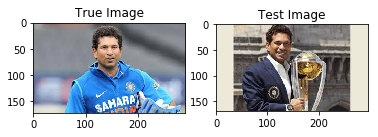

In [25]:
show_image('images/sachin1.jpg','images/sachin2.jpg')

## Adding new entry into database

Found 1 face(s)!


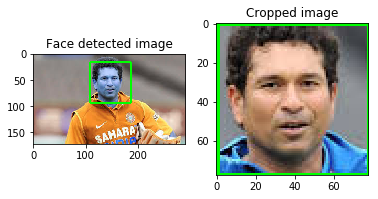

'Sachin added'

In [26]:
add_face("images/sachin1.jpg","Sachin",model)

## Shape of encoded vector

In [28]:
database['Sachin'].shape

(1, 128)

## Testing the model

Found 1 face(s)!


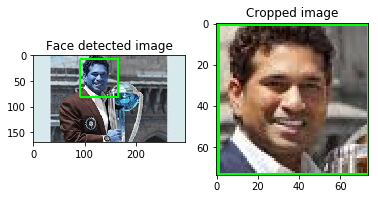

Welcome Sachin,distance is 0.37163812


In [27]:
recog("images/sachin2.jpg",database,model)